In [ ]:
!git clone https://github.com/AlexanderNevarko/glo-flow.git

In [2]:
import sys
sys.path.append('/Users/aleksandr/Desktop/newGAN/glo-flow')
sys.path

['/Users/aleksandr/Desktop/newGAN/glo-flow/notebooks',
 '/Users/aleksandr/miniconda/lib/python38.zip',
 '/Users/aleksandr/miniconda/lib/python3.8',
 '/Users/aleksandr/miniconda/lib/python3.8/lib-dynload',
 '',
 '/Users/aleksandr/miniconda/lib/python3.8/site-packages',
 '/Users/aleksandr/Desktop/hacks/liders/Real-ESRGAN',
 '/Users/aleksandr/miniconda/lib/python3.8/site-packages/IPython/extensions',
 '/Users/aleksandr/.ipython',
 '/Users/aleksandr/Desktop/newGAN/glo-flow']

In [3]:
# !pip install -q nflows

In [4]:
from comet_ml import Experiment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.decomposition import PCA
from sklearn.datasets import fetch_openml
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms as tr

from tqdm.notebook import tqdm

In [5]:
N_COMPONENTS = 32
BW_METHOD = 0.1

### Load the model and get pretrained latents

In [6]:
from modules.dataset import IdxDataset, LatentsDataset, LatentsContextualDataset
from modules.glo_generator import GLOGenerator, GLOModel, SampleGenerator

In [7]:
gen_state_dict = torch.load(
    '/Users/aleksandr/Desktop/newGAN/glo-flow/pretrained/mnist/SOTA_Adam_SparseAdam_z_32_zlr_1e-3_glr_1e-3_100_epochs_model.pth',
map_location=torch.device('cpu'))

In [8]:
latents = gen_state_dict['z.weight']

In [9]:
latents.shape

torch.Size([60000, 32])

In [10]:
dataset = LatentsDataset(latents)

In [11]:
lat_loader = DataLoader(dataset, batch_size=64, shuffle=False)

In [12]:
device = torch.device('cpu')

In [13]:
mnist_train = IdxDataset(MNIST(root='datasets', train=True, transform=tr.ToTensor(), download=True))
sampler_init_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False)

generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         noise_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=sampler_init_train_loader,
                         normalization='ada',
                         lrelu_slope=0).to(device)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, sampler_init_train_loader, sample_generator, sparse=True).to(device)

In [14]:
model.load_state_dict(gen_state_dict)

<All keys matched successfully>

### Flow model

In [15]:
from nflows import transforms, distributions, flows

In [30]:
num_layers = 6
transformations = []
for _ in range(num_layers):
    transformations.append(transforms.ReversePermutation(features=32))
    transformations.append(transforms.MaskedAffineAutoregressiveTransform(features=32, 
                                                                          hidden_features=64,
                                                                          activation=torch.tanh,
                                                                          use_batch_norm=True))
transform = transforms.CompositeTransform(transformations)
base_distribution = distributions.StandardNormal(shape=[32])
flow = flows.Flow(transform=transform, distribution=base_distribution)

In [31]:
optimizer = torch.optim.Adam(flow.parameters())
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [50, 100], gamma=0.2)

In [23]:
device = next(iter(flow.parameters())).device

### Let's train

In [24]:
from modules.train_flow import FlowTrainer

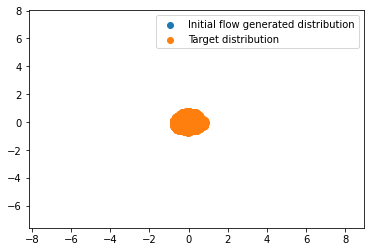

In [32]:
samples = flow.sample(6_000).detach().numpy()
plt.scatter(samples[:, 0], samples[:, 1], label='Initial flow generated distribution')
plt.scatter(latents[:, 0].detach().numpy(), latents[:, 1].detach().numpy(), label='Target distribution')
plt.xlim(left=min(latents[:, 0])*10, right=max(latents[:, 0])*10)
plt.ylim(bottom=min(latents[:, 1])*10, top=max(latents[:, 1])*10)
plt.legend()
plt.show()

In [33]:
experiment = Experiment(api_key='CfFmqDpTCtsdDkLooedZh7bs2',
                        project_name='flow',
                        workspace='alexandernevarko')

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/flow/92ee3f0184ea4b969f9c5bb1b4a84512
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average epoch train loss [7] : (-18.396983539117677, 11.242673416095757)
COMET INFO:     Train loss [6758]            : (-21.55428123474121, 98.36738586425781)
COMET INFO:     loss [1350]                  : (-21.20875358581543, 98.36738586425781)
COMET INFO:   Others:
COMET INFO:     Name : mnist_32_64_tanh_bn
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (503.67 KB)
COMET INFO:     images                   : 7
COMET INFO:     installed packages       : 1
COMET INFO: ---------------

In [34]:
trainer = FlowTrainer(flow, logger=experiment)

In [35]:
trainer.train(120, lat_loader, optimizer, scheduler=scheduler, 
              generator_model=model, exp_name='mnist_32_64_tanh_bn', model_path='')


Average epoch 0 train loss: -11.787819681804317


/Users/aleksandr/miniconda/lib/python3.8/site-packages/torch/nn/functional.py:3454: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(



Average epoch 1 train loss: -18.27220142726451



Average epoch 2 train loss: -19.558312889863686



Average epoch 3 train loss: -20.36262437377149



Average epoch 4 train loss: -20.932668864854108



Average epoch 5 train loss: -21.36271769558189



Average epoch 6 train loss: -21.70106397356306



Average epoch 7 train loss: -21.97684156665924



Average epoch 8 train loss: -22.207947072189754



Average epoch 9 train loss: -22.405341380186428



Average epoch 10 train loss: -22.576545471321545



Average epoch 11 train loss: -22.726889575722375



Average epoch 12 train loss: -22.860231891623947



Average epoch 13 train loss: -22.97954678484626



Average epoch 14 train loss: -23.08729881823444



Average epoch 15 train loss: -23.185421927397186



Average epoch 16 train loss: -23.27527416692868



Average epoch 17 train loss: -23.35786910758598



Average epoch 18 train loss: -23.43411707522264



Average epoch 19 train loss: -23.504702708360227



Average epoch 20 train loss: -23.57024185693086



Average epoch 21 train loss: -23.63139921973255



Average epoch 22 train loss: -23.688821701098608



Average epoch 23 train loss: -23.74292045869807



Average epoch 24 train loss: -23.793990535776754



Average epoch 25 train loss: -23.842266778193558



Average epoch 26 train loss: -23.888002769779295



Average epoch 27 train loss: -23.931439901974155



Average epoch 28 train loss: -23.97279804449346



Average epoch 29 train loss: -24.012262915751574



Average epoch 30 train loss: -24.049955392443042



Average epoch 31 train loss: -24.085987131732868



Average epoch 32 train loss: -24.120465967955113



Average epoch 33 train loss: -24.15349669751328



Average epoch 34 train loss: -24.18511319719652



Average epoch 35 train loss: -24.215506563817005



Average epoch 36 train loss: -24.244759801608414



Average epoch 37 train loss: -24.272906994768807



Average epoch 38 train loss: -24.300006065287317



Average epoch 39 train loss: -24.326147717961877



Average epoch 40 train loss: -24.351408297573325



Average epoch 41 train loss: -24.37581648348745



Average epoch 42 train loss: -24.39932369118306



Average epoch 43 train loss: -24.421983419959226



Average epoch 44 train loss: -24.44373760345394



Average epoch 45 train loss: -24.464739895070284



Average epoch 46 train loss: -24.485125909736162



Average epoch 47 train loss: -24.504897192851313



Average epoch 48 train loss: -24.524067571676618



Average epoch 49 train loss: -24.542616592033077



Average epoch 50 train loss: -25.234167218970846



Average epoch 51 train loss: -25.35154316013556



Average epoch 52 train loss: -25.384281020174658



Average epoch 53 train loss: -25.40734942381316



Average epoch 54 train loss: -25.425951723859253



Average epoch 55 train loss: -25.4418948748981



Average epoch 56 train loss: -25.45605698323199



Average epoch 57 train loss: -25.46893296109588



Average epoch 58 train loss: -25.480830865628175



Average epoch 59 train loss: -25.491955988951077



Average epoch 60 train loss: -25.502450074722518



Average epoch 61 train loss: -25.512415920493446



Average epoch 62 train loss: -25.521930881654786



Average epoch 63 train loss: -25.531054374759893



Average epoch 64 train loss: -25.539835362546224



Average epoch 65 train loss: -25.548311821179094



Average epoch 66 train loss: -25.55651529308067



Average epoch 67 train loss: -25.564472928484367



Average epoch 68 train loss: -25.572206358919775



Average epoch 69 train loss: -25.5797368051655



Average epoch 70 train loss: -25.587083074329758



Average epoch 71 train loss: -25.59426014458955



Average epoch 72 train loss: -25.601280389309945



Average epoch 73 train loss: -25.608151962508018



Average epoch 74 train loss: -25.614883420818142



Average epoch 75 train loss: -25.62148515908703



Average epoch 76 train loss: -25.627963468718377



Average epoch 77 train loss: -25.634329383052997



Average epoch 78 train loss: -25.640586853027344



Average epoch 79 train loss: -25.646741627121784



Average epoch 80 train loss: -25.652797713208553



Average epoch 81 train loss: -25.658757171142838



Average epoch 82 train loss: -25.664628175275922



Average epoch 83 train loss: -25.670414729413192



Average epoch 84 train loss: -25.67611985318442



Average epoch 85 train loss: -25.68174845933406



Average epoch 86 train loss: -25.687304651305112



Average epoch 87 train loss: -25.69278771740033



Average epoch 88 train loss: -25.69819776539101



Average epoch 89 train loss: -25.70354078573459



Average epoch 90 train loss: -25.708821925018896



Average epoch 91 train loss: -25.714041368285223



Average epoch 92 train loss: -25.71919981299687



Average epoch 93 train loss: -25.724296813834705



Average epoch 94 train loss: -25.72933526842325



Average epoch 95 train loss: -25.734321834181927



Average epoch 96 train loss: -25.739255246323054



Average epoch 97 train loss: -25.744136698464594



Average epoch 98 train loss: -25.748964525234978



Average epoch 99 train loss: -25.753745780570675



Average epoch 100 train loss: -25.92900956363312



Average epoch 101 train loss: -25.96446143437042



Average epoch 102 train loss: -25.97053564230262



Average epoch 103 train loss: -25.974304870247586



Average epoch 104 train loss: -25.977248446011085



Average epoch 105 train loss: -25.979772433543257



Average epoch 106 train loss: -25.98204295924986



Average epoch 107 train loss: -25.984142870791178



Average epoch 108 train loss: -25.986120173163506



Average epoch 109 train loss: -25.988004302165148



Average epoch 110 train loss: -25.989815360193315



Average epoch 111 train loss: -25.99156645874479



Average epoch 112 train loss: -25.99326767138581



Average epoch 113 train loss: -25.994926493305133



Average epoch 114 train loss: -25.996548652648926



Average epoch 115 train loss: -25.998138614809083



Average epoch 116 train loss: -25.999699887436336



Average epoch 117 train loss: -26.00123558776465



Average epoch 118 train loss: -26.0027480298268



Average epoch 119 train loss: -26.004239810301044


In [36]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/alexandernevarko/flow/0a86877fed8640f1b4cc736a286b1a8a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Average epoch train loss [120] : (-26.004239810301044, -11.787819681804317)
COMET INFO:     Train loss [112560]            : (-29.823139190673828, 100.08622741699219)
COMET INFO:     loss [22512]                   : (-29.79926300048828, 100.08622741699219)
COMET INFO:   Others:
COMET INFO:     Name : mnist_32_64_tanh_bn
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (503.67 KB)
COMET INFO:     images                   : 120
COMET INFO:     installed packages       : 1
COMET INFO:    

In [33]:
n_epochs = 101
epoch_loss = []
for epoch in tqdm(range(n_epochs)):
    running_loss = []
    for lats, cont in tqdm(lat_loader, leave=False):
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=lats, context=cont).mean()
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
    epoch_loss.append(np.mean(running_loss))
    print(f'Epoch {epoch} mean log prob: {np.mean(epoch_loss)}')
    #Test visualization
    if epoch % 10 == 0:
        samples = flow.sample(6000)
        plt.scatter(samples[:, 0].detach().numpy(), samples[:, 1].detach().numpy(), label=f'{epoch}')
        plt.title(f'Epoch {epoch}')
        plt.show()
    
#     xline = torch.linspace(-1.5, 2.5)
#     yline = torch.linspace(-.75, 1.25)
#     xgrid, ygrid = torch.meshgrid(xline, yline)
#     xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

#     with torch.no_grad():
#         zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)

#     plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
#     plt.title('iteration {}'.format(i + 1))
#     plt.show()
# plt.legend()
# plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x64 and 1x64)

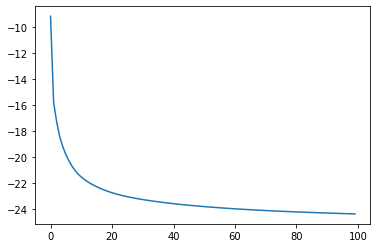

In [124]:
plt.plot(epoch_loss)

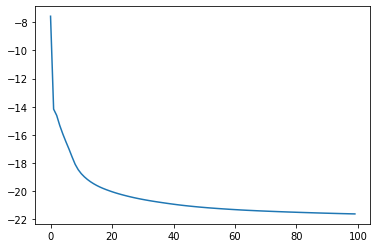

In [57]:
plt.plot(epoch_loss)

### Inference with generator

In [103]:
from modules.glo_generator import GLOGenerator, GLOModel, SampleGenerator
from modules.dataset import IdxDataset

In [72]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [86]:
inverse_transform = tr.ToPILImage()

In [79]:
mnist_train = MNIST(root='datasets', train=True, transform=tr.ToTensor(), download=True)

In [80]:
mnist_train = IdxDataset(mnist_train)

In [105]:
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True, num_workers=1, pin_memory=True)
sampler_init_train_loader = DataLoader(mnist_train, batch_size=64, shuffle=False)

In [107]:
N_COMPONENTS = 32
BW_METHOD = 0.1
generator = GLOGenerator(min_channels=16,
                         max_channels=128,
                         noise_channels=N_COMPONENTS,
                         num_blocks=3,
                         dataloader=train_loader,
                         normalization='ada',
                         lrelu_slope=0).to(device)
sample_generator = SampleGenerator(sampler_init_train_loader, z_dim=N_COMPONENTS, bw_method=BW_METHOD)
model = GLOModel(generator, train_loader, sample_generator, sparse=True).to(device)

In [108]:
model.load_state_dict(gen_state_dict)

<All keys matched successfully>

In [130]:
base_distribution.sample(10).shape

torch.Size([10, 32])

In [134]:
res = model(inputs=flow.sample(10))

In [135]:
imgs = []
for tensor_res in res:
    img = inverse_transform(tensor_res)
    imgs.append(img)

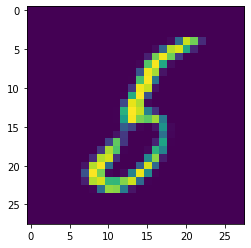

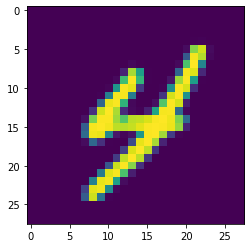

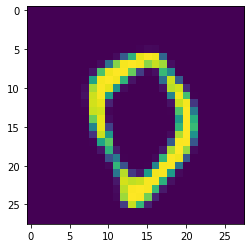

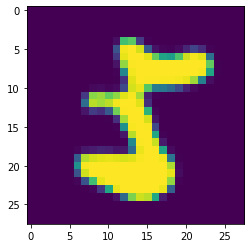

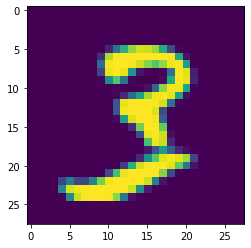

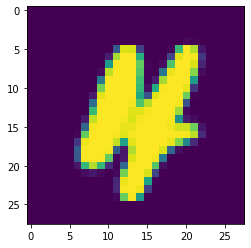

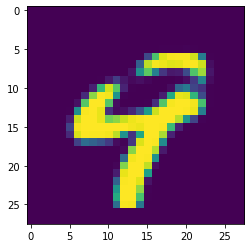

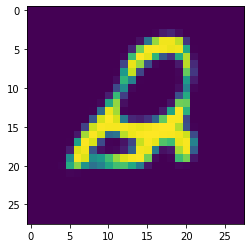

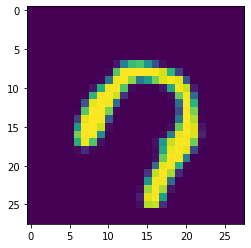

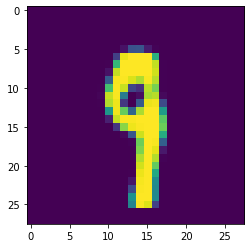

In [136]:
for img in imgs:
    plt.imshow(img)
    plt.show()